
### Initialization

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
from xgboost import XGBClassifier
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Rule 1: Set Global Seeds for Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# File Paths
adnimerge_path = r"C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\dataset\ADNIMERGE_01Feb2026.csv"
apoe_path = r"C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\dataset\APOERES_01Feb2026.csv"

print("Environment initialized. Global SEED set to 42.")

Environment initialized. Global SEED set to 42.


### Data Merging and APOE Encoding
In this cell, we perform Merge Contextual Data. We join the clinical data with the genetic data using the RID. We also implement Label Management by converting the categorical APOE genotypes (e.g., 3/4) into numerical risk scores based on the presence of the ε4 allele.

In [3]:
# 1. Load Datasets
df_adni = pd.read_csv(adnimerge_path, low_memory=False)
df_apoe = pd.read_csv(apoe_path, low_memory=False)

# 2. Filter for Baseline
df_adni_bl = df_adni[df_adni['VISCODE'] == 'bl'].copy()

# 3. Clean APOE Data
# We only need the unique genotype for each patient (RID)
df_apoe_clean = df_apoe[['RID', 'GENOTYPE']].drop_duplicates(subset='RID')

# 4. Merge Contextual Data
# Join clinical baseline with genetic data
df_stage2 = pd.merge(df_adni_bl, df_apoe_clean, on='RID', how='inner')

# 5. Rule 2: Mapping Categorical Genotypes to Risk Markers
# APOE4 count is the standard genetic risk factor
# 0: No e4 alleles (e.g., 3/3, 2/3)
# 1: One e4 allele (e.g., 3/4, 2/4)
# 2: Two e4 alleles (4/4)
def encode_apoe(genotype):
    if pd.isna(genotype): return np.nan
    return str(genotype).count('4')

df_stage2['APOE4_Count'] = df_stage2['GENOTYPE'].apply(encode_apoe)

# Drop rows where genotype or DX_bl is missing
df_stage2 = df_stage2.dropna(subset=['APOE4_Count', 'DX_bl'])

print(f"Merged Dataset Shape: {df_stage2.shape}")
print(f"Unique Genotypes found: {df_stage2['GENOTYPE'].unique()}")

Merged Dataset Shape: (2389, 118)
Unique Genotypes found: <StringArray>
['3/3', '3/4', '2/3', '4/4', '2/4', '2/2']
Length: 6, dtype: str


### Cascade Integration (Stage 1 Output as a Feature)
In this cell, we implement the Cascade Logic. According to the framework, Stage 2 is an escalation. Therefore, the risk probability generated in Stage 1 is a vital "clinical signal" for the Stage 2 model.

In [7]:
# 1. Load Stage 1 artifacts (robust path discovery and checks)
from pathlib import Path
import sys

# Try common relative locations for the stage1 artifacts
cwd = Path.cwd()
candidates = [
    Path('stage1_model.json'),
    Path('stage1_scaler.pkl'),
    Path('stage1_imputer.pkl'),
    Path('stage 1') / 'stage1_model.json',
    Path('stage 1') / 'stage1_scaler.pkl',
    Path('stage 1') / 'stage1_imputer.pkl',
    Path('..') / 'stage 1' / 'stage1_model.json',
    Path('..') / 'stage 1' / 'stage1_scaler.pkl',
    Path('..') / 'stage 1' / 'stage1_imputer.pkl',
    ]

found = {}
for p in candidates:
    if p.exists():
        key = p.name
        found[key] = p.resolve()

# As a fallback, search the workspace for these filenames
def find_file(name):
    # search current folder and one level up to avoid long rglob
    for d in (cwd, cwd.parent):
        matches = list(d.rglob(name))
        if matches:
            return matches[0].resolve()
    return None

for name in ('stage1_model.json','stage1_scaler.pkl','stage1_imputer.pkl'):
    if name not in found:
        f = find_file(name)
        if f:
            found[name] = f

missing = [n for n in ('stage1_model.json','stage1_scaler.pkl','stage1_imputer.pkl') if n not in found]
if missing:
    raise FileNotFoundError(f"Required Stage 1 artifacts not found: {missing}. Looked in {candidates} and workspace root paths.")

# Resolve paths
stage1_model_path = found['stage1_model.json']
stage1_scaler_path = found['stage1_scaler.pkl']
stage1_imputer_path = found['stage1_imputer.pkl']

print(f'Using Stage 1 model: {stage1_model_path}')
print(f'Using scaler: {stage1_scaler_path}')
print(f'Using imputer: {stage1_imputer_path}')

# 2. Load artifacts
from xgboost import XGBClassifier
s1_model = XGBClassifier()
s1_model.load_model(str(stage1_model_path))
s1_scaler = joblib.load(stage1_scaler_path)
s1_imputer = joblib.load(stage1_imputer_path)

# 3. Define the features used in Stage 1
s1_features = ['AGE', 'PTGENDER', 'PTEDUCAT', 'FAQ', 'EcogPtMem', 'EcogPtTotal']

# 4. Preprocess Stage 2 data using Stage 1's logic
# Robust gender mapping (handle numeric or strings)
def map_gender(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (int, float)):
        return int(val)
    v = str(val).strip().lower()
    if v in ('female','f','0'):
        return 0
    if v in ('male','m','1'):
        return 1
    # try numeric in string
    try:
        return int(v)
    except Exception:
        return np.nan

df_stage2['PTGENDER'] = df_stage2['PTGENDER'].apply(map_gender)

# Isolate Stage 1 features from the Stage 2 dataframe (coerce types)
X_s1_features = df_stage2[s1_features].copy()
X_s1_features = X_s1_features.astype(object)  # allow imputer to handle types

# Handle missing values and scaling using Stage 1's fitted objects
X_s1_imputed = s1_imputer.transform(X_s1_features)
X_s1_scaled = s1_scaler.transform(X_s1_imputed)

# 4. Generate the Stage 1 Risk Score
df_stage2['Stage1_Prob'] = s1_model.predict_proba(X_s1_scaled)[:, 1]

# 5. Define Stage 2 Target (Binary Risk)
risk_mapping = {'CN': 0, 'SMC': 0, 'EMCI': 1, 'LMCI': 1, 'AD': 1}
df_stage2['Risk_Label'] = df_stage2['DX_bl'].map(risk_mapping)

print("Stage 1 probabilities successfully integrated as a feature.")
print(f"Sample Stage1_Prob values:\n{df_stage2['Stage1_Prob'].head()}")

Using Stage 1 model: C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\stage 1\stage1_model.json
Using scaler: C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\stage 1\stage1_scaler.pkl
Using imputer: C:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\stage 1\stage1_imputer.pkl
Stage 1 probabilities successfully integrated as a feature.
Sample Stage1_Prob values:
0    0.419417
1    0.986474
2    0.514008
3    0.457981
4    0.380356
Name: Stage1_Prob, dtype: float32


### Stage 2 Data Splitting & Preprocessing
With the Stage 1 risk probabilities integrated, we now prepare the data for the Genetic Risk Stratification model. Following Data Preprocessing & Leakage Prevention, we use GroupShuffleSplit to ensure that patient data does not leak between the training and testing sets.

In this stage, our primary new feature is APOE4_Count. We combine it with the Stage1_Prob to allow the model to learn the additive risk of genetics on top of clinical presentation.

In [8]:
# 1. Define Stage 2 Feature Set
# We use the probability from Stage 1 + the Genetic Marker
stage2_features = ['Stage1_Prob', 'APOE4_Count']
X2 = df_stage2[stage2_features]
y2 = df_stage2['Risk_Label']
groups2 = df_stage2['RID']

# 2. Rule 3: Group-Based Splitting (Leakage Prevention)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_idx2, test_idx2 = next(gss2.split(X2, y2, groups2))

X_train2_raw, X_test2_raw = X2.iloc[train_idx2], X2.iloc[test_idx2]
y_train2, y_test2 = y2.iloc[train_idx2], y2.iloc[test_idx2]

# 3. Rule 3: Sequential Transformation
# Even though APOE and Probabilities are numeric, we scale to ensure 
# optimal XGBoost performance and consistency.
imputer2 = KNNImputer(n_neighbors=5)
scaler2 = StandardScaler()

# Fit only on training data
X_train2_imputed = imputer2.fit_transform(X_train2_raw)
X_train2_scaled = scaler2.fit_transform(X_train2_imputed)

# Transform test data
X_test2_imputed = imputer2.transform(X_test2_raw)
X_test2_scaled = scaler2.transform(X_test2_imputed)

# 4. Rule 4: Persistence
joblib.dump(scaler2, 'stage2_scaler.pkl')
joblib.dump(imputer2, 'stage2_imputer.pkl')

print(f"Stage 2 Preprocessing Complete.")
print(f"Training Samples: {X_train2_scaled.shape[0]} | Testing Samples: {X_test2_scaled.shape[0]}")
print(f"Features: {stage2_features}")

Stage 2 Preprocessing Complete.
Training Samples: 1911 | Testing Samples: 478
Features: ['Stage1_Prob', 'APOE4_Count']


### Stage 2 Model Training and Robust Validation
Following the Advanced Estimators and Statistical Robustness, we will now train the Stage 2 XGBoost classifier. This model uses the clinical risk score from Stage 1 as a baseline and refines it using the APOE4_Count. We use Stratified Group 5-Fold Cross-Validation to ensure the genetic risk stratification is consistent across different patient clusters.

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score

# Rule 1 & 4: Initialize XGBoost with the global SEED
# This model learns how genetics (APOE4) adjusts the clinical probability (Stage1_Prob)
model_stage2 = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3, # Smaller depth as we have fewer, high-signal features
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=SEED,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Rule 5: 5-Fold Stratified Group Cross-Validation
# We use 'groups2' (RID) to ensure patient independence across folds
sgkf2 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

# Cross-Validation scoring (ROC-AUC)
cv_scores2 = cross_val_score(
    model_stage2, 
    X_train2_scaled, 
    y_train2, 
    groups=groups2.iloc[train_idx2], 
    cv=sgkf2, 
    scoring='roc_auc'
)

print(f"--- Stage 2 Cross-Validation Results (ROC-AUC) ---")
print(f"Mean AUC: {cv_scores2.mean():.4f}")
print(f"Std Dev:  {cv_scores2.std():.4f}")

# Train the final model on the full Stage 2 training set
model_stage2.fit(X_train2_scaled, y_train2)

# Rule 4: Persistence - Save the trained model for Stage 2
model_stage2.save_model('stage2_model.json')
print("\nFinal Stage 2 model trained and saved as 'stage2_model.json'.")

--- Stage 2 Cross-Validation Results (ROC-AUC) ---
Mean AUC: 0.9193
Std Dev:  0.0197

Final Stage 2 model trained and saved as 'stage2_model.json'.


c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:50:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:50:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\xgboost\training.py:199: UserWarning: [04:50:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\shar

### Stage 2 Deep Evaluation & Visual Validation
The Stage 2 model shows a Mean AUC of 0.9193, which is an improvement over Stage 1 (0.9080). This indicates that the inclusion of the APOE genotype successfully refines the clinical risk prediction.

--- Stage 2: Detailed Classification Report (Clinical + Genetic) ---
              precision    recall  f1-score   support

    Low Risk       0.75      0.83      0.79       181
   High Risk       0.89      0.83      0.86       297

    accuracy                           0.83       478
   macro avg       0.82      0.83      0.82       478
weighted avg       0.84      0.83      0.83       478



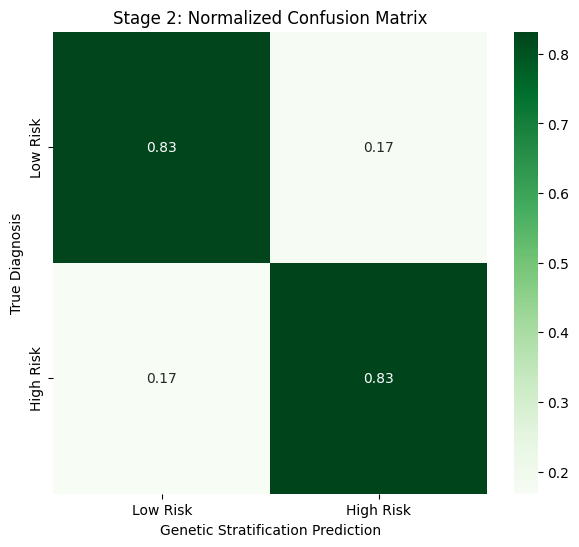

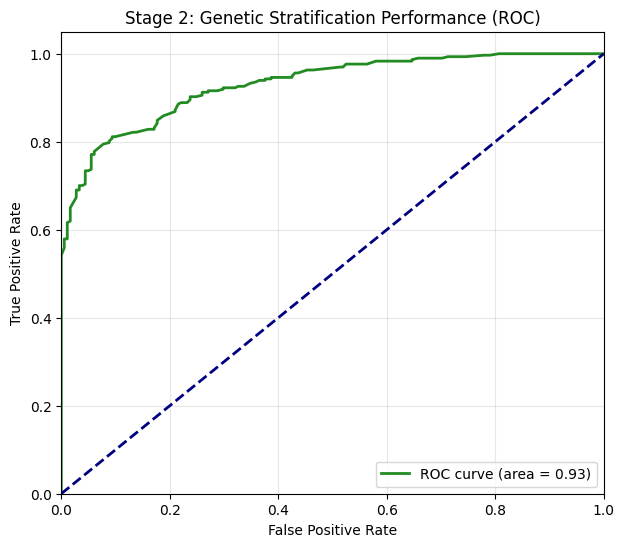

In [10]:
# 1. Generate Predictions
y_pred2 = model_stage2.predict(X_test2_scaled)
y_pred_proba2 = model_stage2.predict_proba(X_test2_scaled)[:, 1]

# 2. Rule 5: Classification Report
print("--- Stage 2: Detailed Classification Report (Clinical + Genetic) ---")
target_names = ['Low Risk', 'High Risk']
print(classification_report(y_test2, y_pred2, target_names=target_names))

# 3. Rule 5: Visual Proof - Normalized Confusion Matrix
cm2 = confusion_matrix(y_test2, y_pred2, normalize='true')
plt.figure(figsize=(7, 6))
sns.heatmap(cm2, annot=True, fmt='.2f', cmap='Greens', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Stage 2: Normalized Confusion Matrix')
plt.ylabel('True Diagnosis')
plt.xlabel('Genetic Stratification Prediction')
plt.show()

# 4. Rule 5: Visual Proof - ROC Curve
fpr2, tpr2, _ = roc_curve(y_test2, y_pred_proba2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(7, 6))
plt.plot(fpr2, tpr2, color='forestgreen', lw=2, label=f'ROC curve (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stage 2: Genetic Stratification Performance (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Cross-Validation Stability & SHAP Analysis (Stage 2)
Following Statistical Robustness and Model Interpretability, we will now visualize the cross-validation stability and break down the "Genetic Weight" using SHAP.

This is critical because it visually proves that adding the APOE genotype actually "tightens" the prediction compared to Stage 1.

c:\Users\shari\OneDrive\Desktop\FLUID MODAL (genetics + biomarker + cognitive scores)\models\b&b\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\shari\AppData\Local\Temp\ipykernel_19640\2126611167.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_test2_scaled, feature_names=stage2_features, plot_type="bar", show=False)


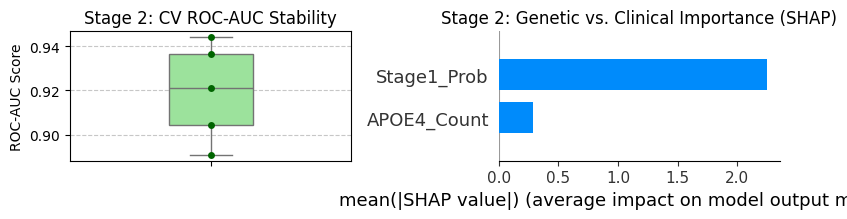

C:\Users\shari\AppData\Local\Temp\ipykernel_19640\2126611167.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_test2_scaled, feature_names=stage2_features, show=False)


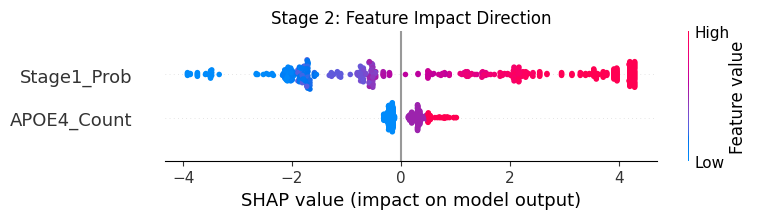

In [11]:
import shap

# 1. Rule 5: Visualizing CV Stability
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=cv_scores2, color='lightgreen', width=0.3)
sns.swarmplot(y=cv_scores2, color='darkgreen')
plt.title('Stage 2: CV ROC-AUC Stability')
plt.ylabel('ROC-AUC Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Rule 6: SHAP Analysis for Stage 2
# This shows how much 'weight' the model gives to Stage 1 risk vs. APOE4 status
explainer2 = shap.TreeExplainer(model_stage2)
shap_values2 = explainer2.shap_values(X_test2_scaled)

plt.subplot(1, 2, 2)
plt.title("Stage 2: Genetic vs. Clinical Importance (SHAP)")
shap.summary_plot(shap_values2, X_test2_scaled, feature_names=stage2_features, plot_type="bar", show=False)

plt.tight_layout()
plt.show()

# 3. Detailed SHAP Summary Plot
plt.figure(figsize=(10, 6))
plt.title("Stage 2: Feature Impact Direction")
shap.summary_plot(shap_values2, X_test2_scaled, feature_names=stage2_features, show=False)
plt.show()

### Demo of the Multi-Stage Framework
To test this as a "demo," we need a cell that simulates the MirAI Escalation Pathway. This cell will take "raw" patient data, pass it through Stage 1, and then use that output to get a "Refined Genetic Risk" from Stage 2.

In [ ]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from pathlib import Path

def _find_artifact(name):
    cwd = Path.cwd()
    for d in (cwd, cwd.parent):
        matches = list(d.rglob(name))
        if matches:
            return matches[0].resolve()
    return None

def mirai_full_demo_s1_s2(patient_profile):
    """
    Simulates the first two stages of the MirAI framework.
    This version uses a small artifact search helper so the demo works
    even when the working directory is different from the artifacts' folder.
    """
    # Locate required artifacts (Stage 1 + Stage 2)
    s1_model_path = _find_artifact('stage1_model.json') or Path('stage1_model.json').resolve()
    s1_scaler_path = _find_artifact('stage1_scaler.pkl') or Path('stage1_scaler.pkl').resolve()
    s1_imputer_path = _find_artifact('stage1_imputer.pkl') or Path('stage1_imputer.pkl').resolve()
    s2_model_path = _find_artifact('stage2_model.json') or Path('stage2_model.json').resolve()
    s2_scaler_path = _find_artifact('stage2_scaler.pkl') or Path('stage2_scaler.pkl').resolve()
    s2_imputer_path = _find_artifact('stage2_imputer.pkl') or Path('stage2_imputer.pkl').resolve()

    missing = [ (name, p) for name,p in [('stage1_model.json',s1_model_path),('stage1_scaler.pkl',s1_scaler_path),('stage1_imputer.pkl',s1_imputer_path),('stage2_model.json',s2_model_path),('stage2_scaler.pkl',s2_scaler_path),('stage2_imputer.pkl',s2_imputer_path)] if not Path(p).exists() ]
    if missing:
        names = [n for n,_ in missing]
        raise FileNotFoundError(f"Missing required artifacts: {names}. Searched current and parent directories.")

    # STAGE 1: CLINICAL SCREENING
    s1_model = XGBClassifier()
    s1_model.load_model(str(s1_model_path))
    s1_scaler = joblib.load(s1_scaler_path)
    s1_imputer = joblib.load(s1_imputer_path)

    s1_features = ['AGE', 'PTGENDER', 'PTEDUCAT', 'FAQ', 'EcogPtMem', 'EcogPtTotal']
    df_s1 = pd.DataFrame([patient_profile], columns=s1_features)
    s1_proc = s1_scaler.transform(s1_imputer.transform(df_s1))
    s1_prob = s1_model.predict_proba(s1_proc)[0][1]

    # STAGE 2: GENETIC STRATIFICATION
    s2_model = XGBClassifier()
    s2_model.load_model(str(s2_model_path))
    s2_scaler = joblib.load(s2_scaler_path)
    s2_imputer = joblib.load(s2_imputer_path)

    apoe_count = str(patient_profile.get('GENOTYPE','')).count('4')
    df_s2 = pd.DataFrame([[s1_prob, apoe_count]], columns=['Stage1_Prob', 'APOE4_Count'])
    s2_proc = s2_scaler.transform(s2_imputer.transform(df_s2))
    s2_prob = s2_model.predict_proba(s2_proc)[0][1]

    # LOGIC OUTPUT
    return {
        "Stage 1 (Clinical) Risk": f"{s1_prob:.2%}",
        "Stage 2 (Genetic) Risk": f"{s2_prob:.2%}",
        "Genetic Impact": "Increased Risk" if s2_prob > s1_prob else "Decreased/Stable Risk",
        "Final Recommendation": "PROCEED TO STAGE 3 (BLOOD TEST)" if s2_prob >= 0.5 else "MONITOR CLINICALLY"
    }

# --- TEST THE DEMO ---
test_profile = {
    'AGE': 70.0,
    'PTGENDER': 1,
    'PTEDUCAT': 16,
    'FAQ': 2.0,
    'EcogPtMem': 2.5,
    'EcogPtTotal': 2.0,
    'GENOTYPE': '4/4'
}

print("--- MirAI Multi-Stage Demo Output ---")
results = mirai_full_demo_s1_s2(test_profile)
for key, val in results.items():
    print(f"{key}: {val}")

--- MirAI Multi-Stage Demo Output ---


XGBoostError: [05:07:11] C:\actions-runner\_work\xgboost\xgboost\src\common\io.cc:144: Opening stage1_model.json failed: The system cannot find the file specified.